In [ ]:
import wave
import struct

In [ ]:
def detect_encoding(file_path):
    encoding = "utf-8"
    try:
        l = open(file_path, 'r', encoding="utf-8").read()
        if l.startswith("\ufeff"):  # byte order mark
            encoding = "utf-8-sig"
    except UnicodeDecodeError:
        try:
            open(file_path, 'r', encoding="utf-16").read()
            encoding = "utf-16"
        except UnicodeError:
            encoding = "cp1251"
    return encoding

In [ ]:
from itertools import product
letters = "GBRY"
nums = "1234"
levels = [ch + num for num, ch in product(nums, letters)]
level_codes = [2 ** i for i in range(len(levels))]

level2code = {i: j for i, j in zip(levels, level_codes)}
code2level = {j: i for i, j in zip(levels, level_codes)}

sampwidth_to_char = {1: "c", 2: "h", 4: "i"}

In [ ]:
class Params:
  def __init__(self, s_rate, s_width, n_channels) -> None:
      self.samplerate = s_rate
      self.sampwidth = s_width
      self.numchannels = n_channels

In [ ]:
class Label:
  def __init__(self, position, level, text) -> None:
    self.position = position
    self.level = level
    self.text = text

In [ ]:
class Seg:
  def __init__(self, filename: str = None, labels: list = [], params: Params = Params(22050, 2, 1)):
    self.filename = filename
    self.labels = labels
    self.params = params

  def read_seg_file(self):
    try:
      with open(self.filename, "r", encoding=detect_encoding(self.filename)) as f:
        lines = [line.strip() for line in f.readlines()]
    except FileNotFoundError:
      print(self.filename, " не найден")

    self.init_params()

    try:
      index_labels = lines.index('[LABELS]')
    except ValueError:
      print("Seg-файл не содержит секции LABELS")

    labels_ = lines[index_labels + 1 :]
    labels_arr = [Label(
        int(line.split(",")[0]) // self.params.sampwidth // self.params.numchannels,
        code2level[int(line.split(",")[1])],
        line.split(",")[2]
    ) for line in labels_ if line.count(",") >= 2]

    self.labels = labels_arr

  def init_params(self):
    try:
      with open(self.filename, "r", encoding=detect_encoding(self.filename)) as f:
        lines = [line.strip() for line in f.readlines()]
    except FileNotFoundError:
      print(self.filename, " не найден")

    try:
      index_params = lines.index('[PARAMETERS]')
    except ValueError:
      print("Seg-файл не содержит секции PARAMETERS")

    try:
      index_labels = lines.index('[LABELS]')
    except ValueError:
      print("Seg-файл не содержит секции LABELS")

    parameters = lines[index_params + 1 : index_labels]

    param_dict = {str(line.split("=")[0]): int(line.split("=")[1]) for line in parameters}

    self.params = Params(param_dict["SAMPLING_FREQ"], param_dict["BYTE_PER_SAMPLE"], param_dict["N_CHANNEL"])

  def write_seg_file(self):
    params = {
        "SAMPLING_FREQ": self.params.samplerate,
        "BYTE_PER_SAMPLE": self.params.sampwidth,
        "CODE": 0,
        "N_CHANNEL": self.params.numchannels,
        "N_LABEL": len(self.labels)
    }
    with open(self.filename, "w", encoding="utf-8") as f:
      f.write("[PARAMETERS]\n")
      for key in params.keys():
        f.write(key + '=' + str(params[key]) + "\n")
      f.write("[LABELS]\n")
      for label in self.labels:
        pos = label.position * self.params.numchannels * self.params.sampwidth
        f.write(f"{pos}, {level2code[label.level]}, {label.text}\n")
    print("Параметры и метки записаны в файл ", self.filename)

    def get_labels_in_pairs(self, num_samples):
      ends = [end.position for start, end in zip(self.labels, self.labels[1:])]
      ends.append(num_samples)
      return [(label.position, ends[i], label.text) for i, label in enumerate(self.labels)]

In [ ]:
class Signal:
  def __init__(self, filename: str, signal: list = [], params: Params = None, seg: Seg = None):
    self.signal: list = signal
    self.filename: str = filename
    self.seg: Seg = seg
    self.params: Params = params

  def init_params(self):
    if self.params is not None:
      return
    if self.seg is not None:
      self.seg.init_params()
      self.params = self.seg.params
    else:
      default_params = Params(22050, 2, 1)
      self.params = default_params

  def read_wav(self):
    try:
      f = wave.open(self.filename)
    except FileNotFoundError:
      print(self.filename, " не найден")

    num_samples = f.getnframes()
    samplerate = f.getframerate()
    sampwidth = f.getsampwidth()
    num_channels = f.getnchannels()

    sampwidth_to_char = {1: "c", 2: "h", 4: "i"}
    fmt = str(num_samples * num_channels) + sampwidth_to_char[sampwidth]

    signal = struct.unpack(fmt, f.readframes(num_samples * num_channels))
    self.signal = signal
    new_params = Params(samplerate, sampwidth, num_channels)
    self.params = new_params

  def read_sbl(self):
    with open(self.filename, "rb") as f:
      raw_signal = f.read()
    num_samples = len(raw_signal) // self.params.sampwidth
    fmt = str(num_samples) + sampwidth_to_char[self.params.sampwidth]
    signal = struct.unpack(fmt, raw_signal)
    self.signal = signal

  def read_sound_file(self):
    self.init_params()
    if self.filename.endswith(".wav"):
        self.read_wav()
    elif self.filename.endswith(".sbl"):
        self.read_sbl()
    else:
        raise ValueError("Неизвестное расширение, ", self.filename)

  def write_wav_file(self):
    num_samples = self.params.samplerate * 2
    sampwidth_to_char = {1: "c", 2: "h", 4: "i"}
    fmt = str(num_samples) + sampwidth_to_char[self.params.sampwidth]

    signal_ = struct.pack(fmt, *self.signal)

    f = wave.open(self.filename, "wb")
    f.setnchannels(self.params.numchannels)
    f.setsampwidth(self.params.sampwidth)
    f.setframerate(self.params.samplerate)
    f.writeframes(signal_)
    f.close()

In [ ]:
filename = r"/content/drive/MyDrive/cta/av15t.wav"
wav_signal = Signal(filename)
wav_signal.read_wav()

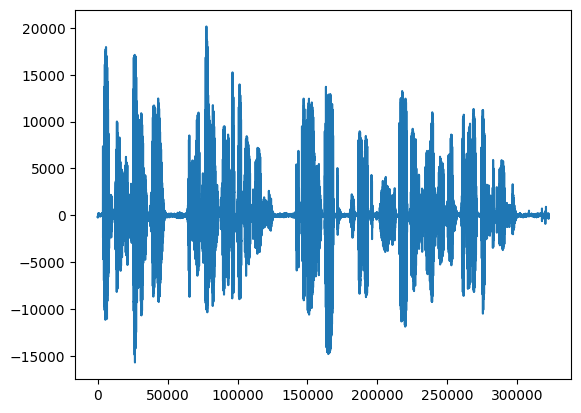

In [ ]:
import matplotlib.pyplot as plt
plt.plot(wav_signal.signal)
plt.show()

In [ ]:
import numpy as np

def get_zeros(wav_signal: list, N_wind):
  sig_len = len(wav_signal)
  res = int(sig_len % (N_wind))
  num_zeros = int(N_wind - res)
  wav_signal.extend(np.zeros(num_zeros))
  return wav_signal

In [ ]:
def detect_pauses(signal_: Signal, w_size: float, min_pause_duration: float, min_alloph_duration: float, threshold: float):
  """
  Функция записывает seg разметку с определением пауз в сигнале
  :param signal: обрабатываемый сигнал
  :param w_size: размер окна обработки сигнала, с
  :param min_pause_duration: минимальная длительность паузы, с
  :param min_alloph_duration: минимальная длительность звучащего сегмента, с
  :param threshold: доля максимальной амплитуды сигнала, ниже которой детектируется пауза
  """

  # Алгоритм:
  # 1. Вычисляем интенсивность сигнала
  # 2. Интервалы выше порога определяем как речевые, ниже - как паузы
  # 3. Объединяем речевые и неречевые интервалы
  # 4. Удаляем короткие паузы (скорее всего, это смычные согласные)
  # 5. Удаляем короткие звучащие сегменты (это не речевые звуки)
  # 6. Пишем seg

  params = signal_.params
  N_wind = int(w_size * params.samplerate / params.sampwidth)

  wav_signal = get_zeros(list(signal_.signal), N_wind)
  num_windows = len(wav_signal) // N_wind

  intensity_list = []
  for i in range(num_windows):
    start = N_wind * i
    end = start + N_wind
    sig_part = np.array(wav_signal[start : end])

    intensity = sig_part ** 2
    intensity_list.append(np.mean(intensity))

  max_intensity = max(intensity_list)
  labels = []

  for i, int_wind in enumerate(intensity_list):
    if np.log(int_wind)/np.log(max_intensity) > threshold:
      labels.append(Label(i * N_wind, "B1", "voiced"))
    else:
      labels.append(Label(i * N_wind, "B1", "pause"))

  labels_united = [labels[0]]
  for label1, label2 in zip(labels, labels[1:]):
    if label1.text != label2.text:
      labels_united.append(label2)

  labels_final = []
  indexes_to_delete = []

  n = 1
  for label1, label2 in zip(labels_united[1:], labels_united[2:]):
    if (label1.text == "pause" and (label2.position - label1.position) / params.samplerate < min_pause_duration) or (label1.text == "voiced" and (label2.position - label1.position) / params.samplerate < min_alloph_duration):
        indexes_to_delete.append(n)
        indexes_to_delete.append(n + 1)
    n += 1

  for i, label in enumerate(labels_united):
    if i not in indexes_to_delete:
      labels_final.append(label)


  new_seg_fn = r"/content/drive/MyDrive/cta/av15t.seg"
  new_seg = Seg(new_seg_fn, labels_final, params)
  new_seg.write_seg_file()


In [ ]:
detect_pauses(wav_signal, 0.02, 0.15, 0.05, 0.6)

Параметры и метки записаны в файл  /content/drive/MyDrive/cta/av15t.seg
